**Model 1 Feature 1: House Price Prediction**

This model is designed to predict the price of a dream home based on user inputs such as location, number of bedrooms, number of bathrooms, land size, building size, electricity capacity, maid's room, and number of floors. Specifically, the model is aimed at predicting house prices in the Jabodetabek (Jakarta, Bogor, Depok, Tangerang, and Bekasi) region using a neural network with a regression algorithm powered by TensorFlow.

The primary objective of this model is to provide accurate house price predictions for users, allowing them to estimate the cost of their desired property in different cities of the Jabodetabek area. The model uses a Linear Regression approach within a neural network architecture to estimate the house prices effectively.

#  Import Library

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Data Preparation

1. The data is divided into two parts:
* X: independent variables (features), which are all columns except price_in_rp.
* y: dependent variable (target), which is the price_in_rp column.
2. Categorical features (city) are converted into numerical representations using one-hot encoding.
3.  Numerical features are normalized using MinMaxScaler to have the same range of values.
4. Data is split into training data (80%) and test data (20%).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
house_data= pd.DataFrame(pd.read_csv("drive/MyDrive/data_clean/house_clean_v3.csv"))

In [ ]:
X = house_data.drop(columns=['price_in_rp'])
y = house_data['price_in_rp']

# One-hot
X_cat = pd.get_dummies(X['city'], drop_first=True)
X_num = X.drop(columns=['city'])

# Normalize
scale_num= MinMaxScaler()
X_num_scaled = scale_num.fit_transform(X_num)

# Combine

X_combined = np.hstack((X_num_scaled, X_cat.values))

# Normalize y
y_mean = y.mean()
y_std = y.std()
y_scaled = (y - y_mean) / y_std

In [ ]:
# Split
split = int(0.8 * len(X_combined))
X_train, X_test = X_combined[:split], X_combined[split:]
y_train, y_test = y_scaled[:split], y_scaled[split:]

# Convert to TensorFlow datasets
train_data= tf.data.Dataset.from_tensor_slices((X_train.astype(np.float32), y_train.astype(np.float32))).batch(32).shuffle(1000)
test_data= tf.data.Dataset.from_tensor_slices((X_test.astype(np.float32), y_test.astype(np.float32))).batch(32)

# Model Architecture

1. The model used is an artificial neural network with several layers:

* Dense: standard fully connected layer.

* BatchNormalization: to normalize activations between layers.

* Dropout: to prevent overfitting.

2. The activation function used is ReLU, except for the output layer which does not use an activation function (linear).
3. The optimizer used is Stochastic Gradient Descent (SGD) with a learning rate of 0.01 and momentum of 0.9.
4. The loss function used is Huber loss.
5. Evaluation metrics used are Mean Absolute Error (MAE) and Mean Squared Error (MSE).

In [ ]:
def create_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.1),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dense(24, activation='relu'),
        Dense(24, activation='relu'),
        Dense(1)
    ])
    return model
model = create_model(X_train.shape[1])
sgd = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=sgd,loss=Huber(delta=1.0),metrics=['mae', 'mse'])

# Model Training
1. The model is trained using the training data (train_data) and validated using the test data (test_data).
2. EarlyStopping is used to stop training if the model's performance on the validation data does not improve for 30 epochs.
3. ReduceLROnPlateau is used to reduce the learning rate if the model's performance on the validation data does not improve for 10 epochs.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)

In [ ]:
history = model.fit(train_data, epochs=200, validation_data=test_data,
                    callbacks=[early_stopping, reduce_lr], verbose=1)

Epoch 1/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 5.5267 - mae: 0.7863 - mse: 1.1462 - val_loss: 4.2537 - val_mae: 0.6460 - val_mse: 0.6894 - learning_rate: 0.0100
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.9051 - mae: 0.5844 - mse: 0.6352 - val_loss: 3.0664 - val_mae: 0.6297 - val_mse: 0.6278 - learning_rate: 0.0100
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7299 - mae: 0.4183 - mse: 0.3994 - val_loss: 2.2618 - val_mae: 0.7043 - val_mse: 0.6028 - learning_rate: 0.0100
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9238 - mae: 0.3589 - mse: 0.2548 - val_loss: 1.6184 - val_mae: 0.5669 - val_mse: 0.4937 - learning_rate: 0.0100
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4221 - mae: 0.3802 - mse: 0.3162 - val_loss: 1.1161 - val_mae: 0.4322 - val_mse: 0.2677 - learning_rate: 0.0100
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0074 - mae: 0.3172 - mse: 0.2083 - val_loss: 0.8619 - val_mae: 0.4762 - v

# Results and Evaluation Model

In [ ]:
test_loss, test_mae, test_mse = model.evaluate(test_data)
y_pred = model.predict(X_test)
r2 = r2_score(y_test * y_std + y_mean, y_pred.flatten() * y_std + y_mean)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}, Test R2 Score: {r2:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1030 - mae: 0.3122 - mse: 0.1822
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Test Loss: 0.0895, Test MAE: 0.2858, Test R2 Score: 0.8197


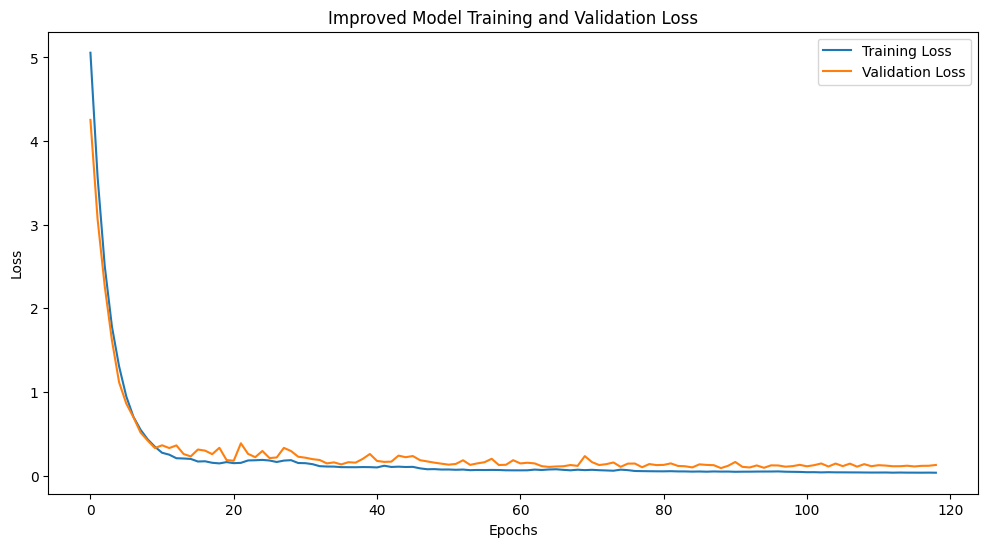

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Improved Model Training and Validation Loss')
plt.show()

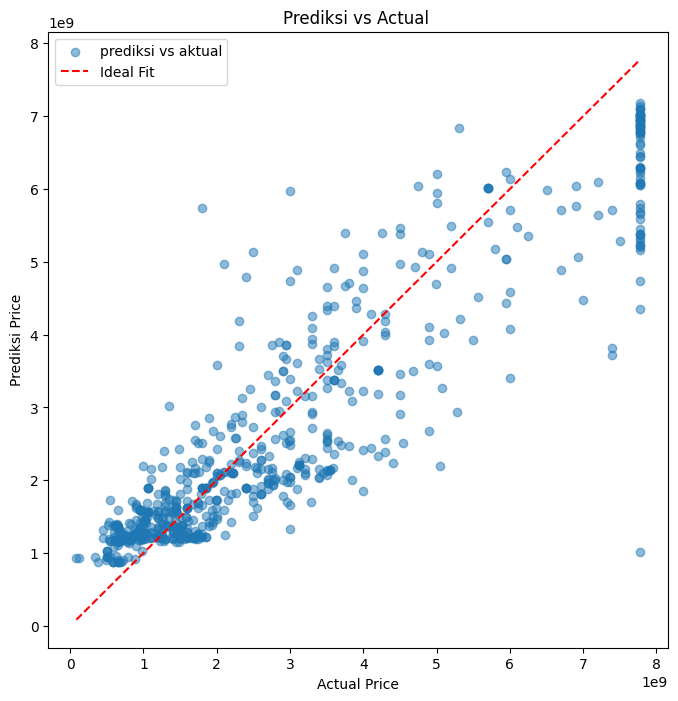

In [ ]:
y_actual = y_test * y_std + y_mean
y_pred_actual = y_pred.flatten() * y_std + y_mean

plt.figure(figsize=(8, 8))
plt.scatter(y_actual, y_pred_actual, alpha=0.5, label='prediksi vs aktual')
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual Price')
plt.ylabel('Prediksi Price')
plt.title('Prediksi vs Actual ')
plt.legend()
plt.show()

In [ ]:
model.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_155 (Dense)                    │ (None, 512)                 │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_75               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_156 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_76               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_157 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_77               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_158 (Dense)                    │ (None, 24)                  │           3,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_159 (Dense)                    │ (None, 16)                  │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_160 (Dense)                    │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 357,236 (1.36 MB)

 Trainable params: 177,721 (694.22 KB)

 Non-trainable params: 1,792 (7.00 KB)

 Optimizer params: 177,723 (694.23 KB)

# Save model

In [ ]:
model.save('house_fix.h5')
print("Model  disimpan")

Model  disimpan


In [ ]:
model.save('house_fix.keras')
print("Model berhasil disimpan dalam format .keras")

Model berhasil disimpan dalam format .keras


In [ ]:
print(model.input_shape)

(None, 15)


# Predictions

In [ ]:
data_baru = pd.DataFrame({
    'city': ['Bekasi'],
    'bedrooms': [3],
    'bathrooms': [4],
    'land_size_m2': [119],
    'building_size_m2': [131],
    'electricity': [2200],
    'maid_bedrooms': [1],
    'floors': [2]
})
X_cat_baru = pd.get_dummies(data_baru['city'], drop_first=True)
all = X['city'].unique()

# Add missing city columns to X_cat_baru
for city in all:
    if city not in X_cat_baru.columns:
        X_cat_baru[city] = 0

X_cat_baru = X_cat_baru[X_cat.columns]

X_num_baru = data_baru.drop(columns=['city'])

X_num_scaled_baru = scale_num.transform(X_num_baru)

X_combined_baru = np.hstack((X_num_scaled_baru, X_cat_baru.values))

# Prediksi
y_pred_baru = model.predict(X_combined_baru)

# Inverse scaling
y_pred_actual_baru = y_pred_baru.flatten() * y_std + y_mean
y_pred_actual = np.expm1(y_pred.flatten())

print("Hasil prediksi harga (dalam rupiah):", y_pred_actual_baru)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Hasil prediksi harga (dalam rupiah): [1.936194e+09]


In [ ]:
data_baru = pd.DataFrame({
    'city': ['Bekasi'],
    'bedrooms': [1],
    'bathrooms': [1],
    'land_size_m2': [60],
    'building_size_m2': [60],
    'electricity': [1300],
    'maid_bedrooms': [0],
    'floors': [1]
})
X_cat_baru = pd.get_dummies(data_baru['city'], drop_first=True)
all = X['city'].unique()

# Add missing city columns to X_cat_baru
for city in all:
    if city not in X_cat_baru.columns:
        X_cat_baru[city] = 0

X_cat_baru = X_cat_baru[X_cat.columns]

X_num_baru = data_baru.drop(columns=['city'])

X_num_scaled_baru = scale_num.transform(X_num_baru)

X_combined_baru = np.hstack((X_num_scaled_baru, X_cat_baru.values))

# Prediksi
y_pred_baru = model.predict(X_combined_baru)

# Inverse scaling
y_pred_actual_baru = y_pred_baru.flatten() * y_std + y_mean
y_pred_actual = np.expm1(y_pred.flatten())

print("Hasil prediksi harga (dalam rupiah):", y_pred_actual_baru)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Hasil prediksi harga (dalam rupiah): [6.787048e+08]


In [ ]:
!pip list

Package                            Version
---------------------------------- --------------------
absl-py                            1.4.0
accelerate                         1.1.1
aiohappyeyeballs                   2.4.3
aiohttp                            3.11.1
aiosignal                          1.3.1
alabaster                          1.0.0
albucore                           0.0.19
albumentations                     1.4.20
altair                             4.2.2
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.5.1
arviz                              0.20.0
astropy                            6.1.6
astropy-iers-data                  0.2024.11.11.0.32.38
astunparse                         1.6.3
async-timeout                      4.0.3
atpublic                           4.1.0
attrs                              24.2.0
audioread         

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sklearn
import matplotlib
print("TensorFlow version:", tf.__version__)
print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("Matplotlib version:", matplotlib.__version__)

TensorFlow version: 2.17.1
Pandas version: 2.2.2
NumPy version: 1.26.4
Scikit-learn version: 1.5.2
Matplotlib version: 3.8.0
